
### MongoDB for This Data:

1. **Flexible Schema:** Products have nested price history, transactions have nested items
2. **Good for Complex Documents:** Each transaction can have different numbers of items
3. **Powerful Aggregation:** MongoDB pipelines let me do complex analysis
4. **Suitable Data Size:** 500K transactions and 10K users work well in MongoDB

---
## Step 1: Connect to MongoDB

First, I need to connect to my local MongoDB server. I'm using the `pymongo` library which is the official Python driver for MongoDB.

In [4]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Import the MongoDB library
from pymongo import MongoClient
import json
from datetime import datetime

# Connect to MongoDB running on my local machine
# Default port is 27017
client = MongoClient("mongodb://localhost:27017/")

# Select my database
db = client["ecommerce_analytics"]

print("Successfully connected to MongoDB!")
print("Database: ecommerce_analytics")
print("Collections available:", db.list_collection_names())

Successfully connected to MongoDB!
Database: ecommerce_analytics
Collections available: ['categories', 'transactions', 'users', 'products', 'sessions']


---
## Step 2: Explore the Data

Let me check how much data I have in each collection and show some sample documents.

In [6]:
# Count documents in each collection
print("=" * 50)
print("DATA SUMMARY")
print("=" * 50)
print(f"Categories:   {db.categories.count_documents({}):>12,} documents")
print(f"Products:     {db.products.count_documents({}):>12,} documents")
print(f"Users:        {db.users.count_documents({}):>12,} documents")
print(f"Transactions: {db.transactions.count_documents({}):>12,} documents")
print(f"Sessions:     {db.sessions.count_documents({}):>12,} documents")
print("=" * 50)

DATA SUMMARY
Categories:             25 documents
Products:            5,000 documents
Users:              10,000 documents
Transactions:      500,000 documents
Sessions:        2,000,000 documents


In [7]:
# Show a sample user document
print("SAMPLE USER DOCUMENT:")
print("-" * 50)
sample_user = db.users.find_one()
for key, value in sample_user.items():
    print(f"  {key}: {value}")

SAMPLE USER DOCUMENT:
--------------------------------------------------
  _id: 69711e721f02784cd40485ca
  user_id: user_000000
  geo_data: {'city': 'Mcintoshton', 'state': 'MO', 'country': 'US'}
  registration_date: 2025-07-21T07:47:54
  last_active: 2025-09-29T06:00:51


In [8]:
# Show a sample product document
print("SAMPLE PRODUCT DOCUMENT:")
print("-" * 50)
sample_product = db.products.find_one()
for key, value in sample_product.items():
    if key == 'price_history':
        print(f"  {key}: [showing first entry] {value[0] if value else 'empty'}")
    else:
        print(f"  {key}: {value}")

SAMPLE PRODUCT DOCUMENT:
--------------------------------------------------
  _id: 69711e721f02784cd4047242
  product_id: prod_00000
  name: Synchronized Bi-Directional Help-Desk
  category_id: cat_016
  base_price: 371.3
  current_stock: 369
  is_active: True
  price_history: [showing first entry] {'price': 459.65, 'date': '2025-08-04T00:17:59'}
  creation_date: 2025-08-04T00:17:59


In [9]:
# Show a sample transaction document
print("SAMPLE TRANSACTION DOCUMENT:")
print("-" * 50)
sample_txn = db.transactions.find_one()
for key, value in sample_txn.items():
    if key == 'items':
        print(f"  {key}: [showing first item] {value[0] if value else 'empty'}")
    else:
        print(f"  {key}: {value}")

SAMPLE TRANSACTION DOCUMENT:
--------------------------------------------------
  _id: 69711e761f02784cd404acda
  transaction_id: txn_439efbca0fdf
  session_id: None
  user_id: user_009014
  timestamp: 2025-10-23T10:46:30
  items: [showing first item] {'product_id': 'prod_01613', 'quantity': 3, 'unit_price': 116.12, 'subtotal': 348.36}
  subtotal: 1136.95
  discount: 0
  total: 1136.95
  payment_method: gift_card
  status: processing


---
## Step 3: MongoDB Schema Design

I designed my MongoDB schema with the following collections:

### Collection: users
```
{
    user_id: "user_000001",
    geo_data: {
        city: "New York",
        state: "NY",
        country: "US"
    },
    registration_date: "2025-08-15T10:30:00",
    last_active: "2025-12-20T14:22:00"
}
```

### Collection: products
```
{
    product_id: "prod_00001",
    name: "Premium Wireless Headphones",
    category_id: "cat_001",
    base_price: 149.99,
    current_stock: 45,
    is_active: true,
    price_history: [
        {price: 139.99, date: "2025-10-15"},
        {price: 149.99, date: "2025-12-01"}
    ]
}
```

### Collection: transactions
```
{
    transaction_id: "txn_abc123",
    user_id: "user_000042",
    timestamp: "2025-12-15T14:45:00",
    items: [
        {product_id: "prod_00123", quantity: 2, unit_price: 99.99, subtotal: 199.98}
    ],
    total: 179.99,
    payment_method: "credit_card",
    status: "completed"
}
```

**Why this design?**
- I embedded items inside transactions because they are always accessed together
- I embedded price_history inside products to track price changes over time
- I kept users, products, and transactions as separate collections for flexibility

---
# MongoDB Aggregation Pipelines

## What is an Aggregation Pipeline?

An aggregation pipeline is like an assembly line in a factory:
- Data goes in at one end
- Each stage transforms the data
- Final result comes out at the other end

I will run 5 pipelines to answer important business questions.

---
## Pipeline 1: Top 10 Best-Selling Products

**Business Question:** What are our top 10 best-selling products by quantity sold?

**Why This Matters:**
- Identifies which products to keep in stock
- Shows what customers want most
- Helps with inventory planning

In [10]:
# Pipeline 1: Top 10 Best-Selling Products
# I use $unwind to break apart the items array, then $group to sum quantities

pipeline_1 = [
    # Stage 1: Unwind the items array
    # Each transaction has multiple items, this creates one row per item
    {"$unwind": "$items"},
    
    # Stage 2: Group by product_id and calculate totals
    {"$group": {
        "_id": "$items.product_id",
        "total_quantity": {"$sum": "$items.quantity"},
        "total_revenue": {"$sum": "$items.subtotal"},
        "times_purchased": {"$sum": 1}
    }},
    
    # Stage 3: Sort by quantity (highest first)
    {"$sort": {"total_quantity": -1}},
    
    # Stage 4: Take only top 10
    {"$limit": 10},
    
    # Stage 5: Join with products collection to get product name
    {"$lookup": {
        "from": "products",
        "localField": "_id",
        "foreignField": "product_id",
        "as": "product_info"
    }},
    
    # Stage 6: Flatten the product_info array
    {"$unwind": "$product_info"},
    
    # Stage 7: Clean up output
    {"$project": {
        "_id": 0,
        "product_id": "$_id",
        "product_name": "$product_info.name",
        "total_quantity": 1,
        "total_revenue": {"$round": ["$total_revenue", 2]},
        "times_purchased": 1
    }}
]

# Execute the pipeline
results_1 = list(db.transactions.aggregate(pipeline_1))

# Display results
print("=" * 70)
print("PIPELINE 1: TOP 10 BEST-SELLING PRODUCTS")
print("=" * 70)
print(f"{'Rank':<6}{'Product ID':<15}{'Product Name':<30}{'Qty Sold':>10}{'Revenue':>12}")
print("-" * 70)

for i, product in enumerate(results_1, 1):
    name = product['product_name'][:28] if product['product_name'] else 'N/A'
    print(f"{i:<6}{product['product_id']:<15}{name:<30}{product['total_quantity']:>10,}${product['total_revenue']:>11,.2f}")

PIPELINE 1: TOP 10 BEST-SELLING PRODUCTS
Rank  Product ID     Product Name                    Qty Sold     Revenue
----------------------------------------------------------------------
1     prod_04321     Robust Reciprocal Open Archi         690$  88,644.30
2     prod_00339     Vision-Oriented Systemic Loc         679$ 208,446.21
3     prod_04672     Assimilated Empowering Archi         667$ 203,381.64
4     prod_01839     Decentralized Multi-State Se         661$  64,731.73
5     prod_03505     Compatible Web-Enabled Succe         653$ 103,252.36
6     prod_02871     Digitized Value-Added Protoc         652$ 201,539.72
7     prod_02478     Virtual Zero-Defect Initiati         648$ 261,202.32
8     prod_00486     Synergistic Fault-Tolerant S         641$ 142,519.94
9     prod_02364     Centralized Optimizing Monit         638$  87,272.02
10    prod_02208     Object-Based Asymmetric Moni         637$ 330,157.10


**My Analysis:**

The top-selling products show which items are most popular with customers. I can use this information to:
- Ensure these products are always in stock
- Feature them prominently on the website
- Consider creating bundles with these popular items

---
## Pipeline 2: Revenue by Category

**Business Question:** Which product categories generate the most revenue?

**Why This Matters:**
- Shows which departments are most profitable
- Helps allocate marketing budget
- Identifies underperforming categories

In [11]:
# Pipeline 2: Revenue by Category
# I join transactions with products to get category, then sum revenue

pipeline_2 = [
    # Stage 1: Unwind items
    {"$unwind": "$items"},
    
    # Stage 2: Lookup product details
    {"$lookup": {
        "from": "products",
        "localField": "items.product_id",
        "foreignField": "product_id",
        "as": "product"
    }},
    {"$unwind": "$product"},
    
    # Stage 3: Lookup category details
    {"$lookup": {
        "from": "categories",
        "localField": "product.category_id",
        "foreignField": "category_id",
        "as": "category"
    }},
    {"$unwind": "$category"},
    
    # Stage 4: Group by category
    {"$group": {
        "_id": {
            "category_id": "$product.category_id",
            "category_name": "$category.name"
        },
        "total_revenue": {"$sum": "$items.subtotal"},
        "total_items_sold": {"$sum": "$items.quantity"},
        "transaction_count": {"$sum": 1}
    }},
    
    # Stage 5: Sort by revenue
    {"$sort": {"total_revenue": -1}},
    
    # Stage 6: Limit to top 10
    {"$limit": 10},
    
    # Stage 7: Clean up
    {"$project": {
        "_id": 0,
        "category_id": "$_id.category_id",
        "category_name": "$_id.category_name",
        "total_revenue": {"$round": ["$total_revenue", 2]},
        "total_items_sold": 1,
        "avg_item_value": {"$round": [{"$divide": ["$total_revenue", "$total_items_sold"]}, 2]}
    }}
]

results_2 = list(db.transactions.aggregate(pipeline_2))

print("=" * 70)
print("PIPELINE 2: TOP 10 CATEGORIES BY REVENUE")
print("=" * 70)
print(f"{'Rank':<6}{'Category':<30}{'Revenue':>15}{'Items Sold':>12}")
print("-" * 70)

for i, cat in enumerate(results_2, 1):
    name = cat['category_name'][:28] if cat['category_name'] else 'N/A'
    print(f"{i:<6}{name:<30}${cat['total_revenue']:>14,.2f}{cat['total_items_sold']:>12,}")

PIPELINE 2: TOP 10 CATEGORIES BY REVENUE
Rank  Category                              Revenue  Items Sold
----------------------------------------------------------------------
1     Cameron-Parsons               $ 22,298,503.07      80,854
2     Kelly-Santiago                $ 21,887,632.49      86,247
3     Anderson, Walls and Duncan    $ 21,435,205.65      86,757
4     Burns-Rodriguez               $ 20,734,898.15      78,977
5     Powell PLC                    $ 20,680,931.61      82,714
6     Mitchell-Kim                  $ 20,679,749.65      77,540
7     Phillips Inc                  $ 20,287,162.64      83,296
8     Carney-Santos                 $ 20,108,661.81      80,703
9     Spence PLC                    $ 19,993,805.01      73,512
10    Hancock Inc                   $ 19,982,373.73      85,337


---
## Pipeline 3: Customer Segmentation by Spending

**Business Question:** How are customers distributed by their total spending?

**Why This Matters:**
- Identifies VIP customers for special treatment
- Shows customer value distribution
- Helps target marketing campaigns

**My Segments:**
- **VIP:** > $50,000 total spending
- **High Value:** $10,000 - $50,000
- **Medium:** $1,000 - $10,000
- **Low:** < $1,000

In [12]:
# Pipeline 3: Customer Segmentation
# I group by user, calculate total spending, then categorize into segments

pipeline_3 = [
    # Stage 1: Group by user and calculate totals
    {"$group": {
        "_id": "$user_id",
        "total_spent": {"$sum": "$total"},
        "order_count": {"$sum": 1},
        "avg_order_value": {"$avg": "$total"}
    }},
    
    # Stage 2: Add segment based on spending
    {"$addFields": {
        "segment": {
            "$switch": {
                "branches": [
                    {"case": {"$gte": ["$total_spent", 50000]}, "then": "VIP"},
                    {"case": {"$gte": ["$total_spent", 10000]}, "then": "High Value"},
                    {"case": {"$gte": ["$total_spent", 1000]}, "then": "Medium"}
                ],
                "default": "Low"
            }
        }
    }},
    
    # Stage 3: Group by segment
    {"$group": {
        "_id": "$segment",
        "customer_count": {"$sum": 1},
        "total_revenue": {"$sum": "$total_spent"},
        "avg_spending": {"$avg": "$total_spent"},
        "avg_orders": {"$avg": "$order_count"}
    }},
    
    # Stage 4: Sort by revenue
    {"$sort": {"total_revenue": -1}},
    
    # Stage 5: Clean up
    {"$project": {
        "_id": 0,
        "segment": "$_id",
        "customer_count": 1,
        "total_revenue": {"$round": ["$total_revenue", 2]},
        "avg_spending": {"$round": ["$avg_spending", 2]},
        "avg_orders": {"$round": ["$avg_orders", 1]}
    }}
]

results_3 = list(db.transactions.aggregate(pipeline_3))

print("=" * 70)
print("PIPELINE 3: CUSTOMER SEGMENTATION BY SPENDING")
print("=" * 70)
print(f"{'Segment':<15}{'Customers':>12}{'Total Revenue':>18}{'Avg Spending':>15}{'Avg Orders':>12}")
print("-" * 70)

total_customers = sum(r['customer_count'] for r in results_3)
for segment in results_3:
    pct = (segment['customer_count'] / total_customers * 100)
    print(f"{segment['segment']:<15}{segment['customer_count']:>8,} ({pct:>5.1f}%)  ${segment['total_revenue']:>14,.2f}  ${segment['avg_spending']:>12,.2f}{segment['avg_orders']:>12.1f}")

PIPELINE 3: CUSTOMER SEGMENTATION BY SPENDING
Segment           Customers     Total Revenue   Avg Spending  Avg Orders
----------------------------------------------------------------------
High Value        6,472 ( 64.7%)  $273,952,211.87  $   42,328.83        46.5
VIP               3,528 ( 35.3%)  $196,713,308.19  $   55,757.74        56.4


**My Analysis:**

The customer segmentation shows that:
- VIP customers are a smaller percentage but generate significant revenue
- We should focus on retaining high-value customers with loyalty programs
- Medium segment customers could be upgraded with targeted promotions

---
## Pipeline 4: Monthly Revenue Trends

**Business Question:** How does revenue change month over month?

**Why This Matters:**
- Shows seasonal patterns
- Identifies growth or decline
- Helps with forecasting

In [13]:
# Pipeline 4: Monthly Revenue Trends
# I extract month from timestamp, then group and sum revenue

pipeline_4 = [
    # Stage 1: Convert timestamp to date and extract month
    {"$addFields": {
        "order_date": {"$toDate": "$timestamp"}
    }},
    
    # Stage 2: Group by year-month
    {"$group": {
        "_id": {
            "year": {"$year": "$order_date"},
            "month": {"$month": "$order_date"}
        },
        "revenue": {"$sum": "$total"},
        "orders": {"$sum": 1},
        "avg_order_value": {"$avg": "$total"}
    }},
    
    # Stage 3: Sort by date
    {"$sort": {"_id.year": 1, "_id.month": 1}},
    
    # Stage 4: Format output
    {"$project": {
        "_id": 0,
        "year": "$_id.year",
        "month": "$_id.month",
        "revenue": {"$round": ["$revenue", 2]},
        "orders": 1,
        "avg_order_value": {"$round": ["$avg_order_value", 2]}
    }}
]

results_4 = list(db.transactions.aggregate(pipeline_4))

print("=" * 70)
print("PIPELINE 4: MONTHLY REVENUE TRENDS")
print("=" * 70)
print(f"{'Month':<15}{'Revenue':>18}{'Orders':>12}{'Avg Order':>15}")
print("-" * 70)

month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month_data in results_4:
    month_str = f"{month_names[month_data['month']]} {month_data['year']}"
    print(f"{month_str:<15}${month_data['revenue']:>16,.2f}{month_data['orders']:>12,}  ${month_data['avg_order_value']:>12,.2f}")

PIPELINE 4: MONTHLY REVENUE TRENDS
Month                     Revenue      Orders      Avg Order
----------------------------------------------------------------------
Oct 2025       $   47,612,412.03      50,819  $      936.90
Nov 2025       $  157,349,131.17     166,692  $      943.95
Dec 2025       $  162,270,959.79     172,284  $      941.88
Jan 2026       $  103,433,017.07     110,205  $      938.55


---
## Pipeline 5: Session Conversion by Device Type

**Business Question:** Which devices have the highest conversion rates?

**Why This Matters:**
- Shows where to focus UX improvements
- Identifies device-specific issues
- Helps prioritize mobile vs desktop development

In [14]:
# Pipeline 5: Conversion by Device
# I group sessions by device type and calculate conversion rate

pipeline_5 = [
    # Stage 1: Group by device type and conversion status
    {"$group": {
        "_id": {
            "device": "$device_profile.type",
            "converted": {"$cond": [{"$eq": ["$conversion_status", "converted"]}, 1, 0]}
        },
        "count": {"$sum": 1}
    }},
    
    # Stage 2: Reshape to get conversions and totals
    {"$group": {
        "_id": "$_id.device",
        "total_sessions": {"$sum": "$count"},
        "conversions": {"$sum": {"$multiply": ["$_id.converted", "$count"]}}
    }},
    
    # Stage 3: Calculate conversion rate
    {"$addFields": {
        "conversion_rate": {
            "$round": [{"$multiply": [{"$divide": ["$conversions", "$total_sessions"]}, 100]}, 2]
        }
    }},
    
    # Stage 4: Sort by conversion rate
    {"$sort": {"conversion_rate": -1}},
    
    # Stage 5: Clean up
    {"$project": {
        "_id": 0,
        "device": "$_id",
        "total_sessions": 1,
        "conversions": 1,
        "conversion_rate": 1
    }}
]

results_5 = list(db.sessions.aggregate(pipeline_5))

print("=" * 70)
print("PIPELINE 5: SESSION CONVERSION BY DEVICE TYPE")
print("=" * 70)
print(f"{'Device':<15}{'Sessions':>15}{'Conversions':>15}{'Conv. Rate':>15}")
print("-" * 70)

for device in results_5:
    print(f"{device['device']:<15}{device['total_sessions']:>15,}{device['conversions']:>15,}{device['conversion_rate']:>14.2f}%")

PIPELINE 5: SESSION CONVERSION BY DEVICE TYPE
Device                Sessions    Conversions     Conv. Rate
----------------------------------------------------------------------
mobile                 666,571         73,523         11.03%
tablet                 666,962         73,404         11.01%
desktop                666,467         73,060         10.96%


---
## Visualizations

Now I will create charts to visualize the MongoDB query results.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results to DataFrames
df_categories = pd.DataFrame(results_2)
df_segments = pd.DataFrame(results_3)
df_monthly = pd.DataFrame(results_4)
df_devices = pd.DataFrame(results_5)

print("Data ready for visualization!")

Data ready for visualization!


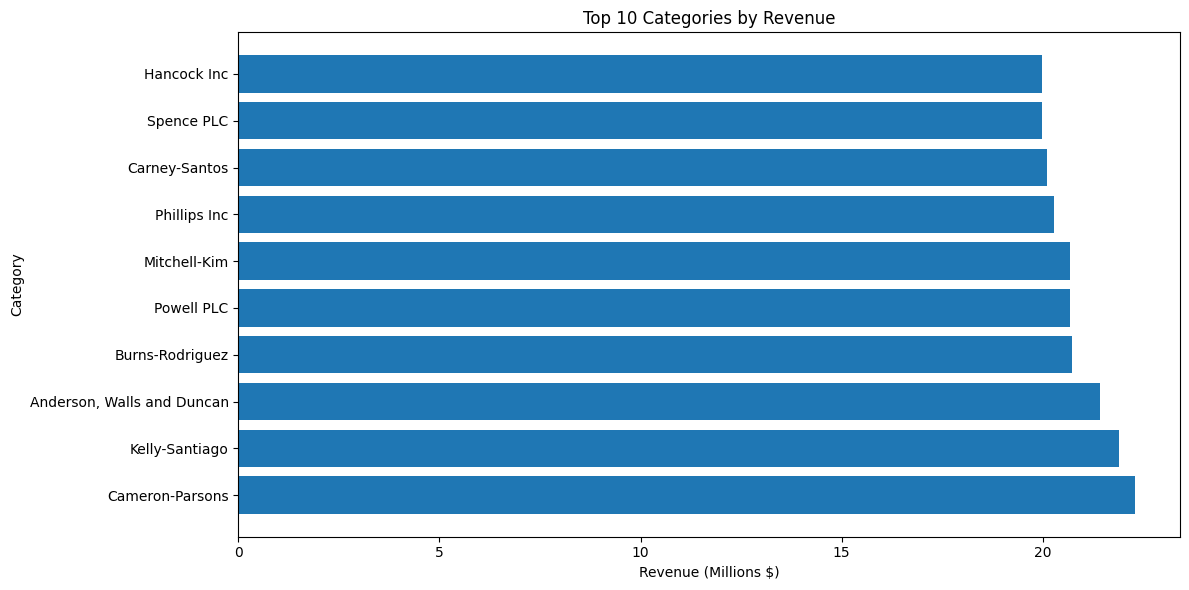

In [16]:
# Chart 1: Revenue by Category (Top 10)
plt.figure(figsize=(12, 6))
plt.barh(df_categories['category_name'].head(10), df_categories['total_revenue'].head(10) / 1000000)
plt.xlabel('Revenue (Millions $)')
plt.ylabel('Category')
plt.title('Top 10 Categories by Revenue')
plt.tight_layout()
plt.show()

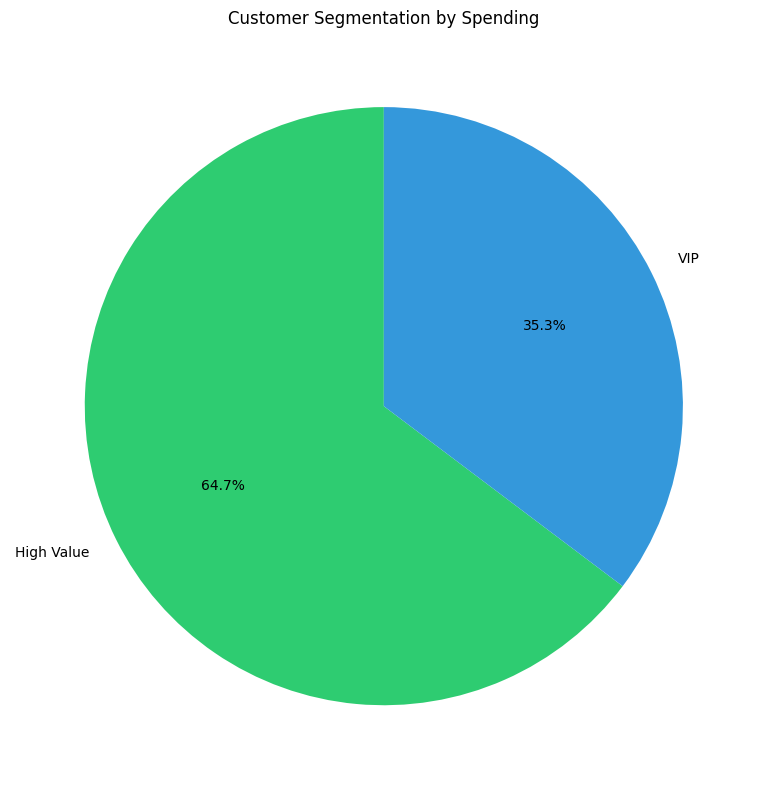

In [17]:
# Chart 2: Customer Segmentation Pie Chart
plt.figure(figsize=(8, 8))
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
plt.pie(df_segments['customer_count'], labels=df_segments['segment'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Customer Segmentation by Spending')
plt.tight_layout()
plt.show()

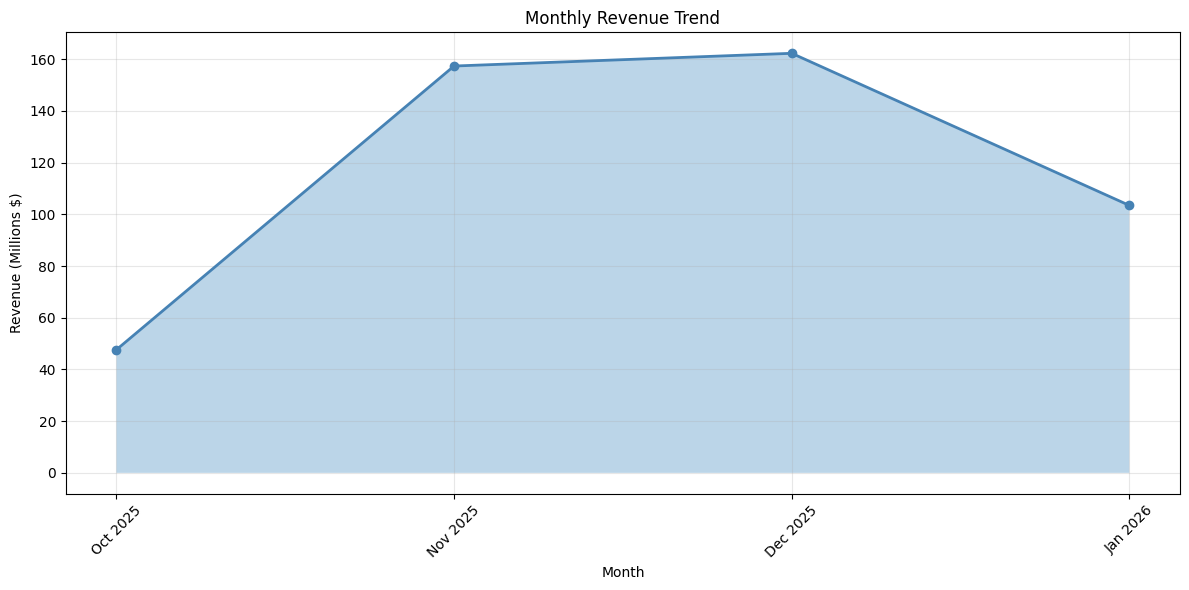

In [19]:
# Chart 3: Monthly Revenue Trend
df_monthly['month_label'] = df_monthly.apply(lambda x: f"{['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][int(x['month'])]} {int(x['year'])}", axis=1)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['month_label'], df_monthly['revenue'] / 1000000, marker='o', linewidth=2, color='steelblue')
plt.fill_between(range(len(df_monthly)), df_monthly['revenue'] / 1000000, alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Revenue (Millions $)')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

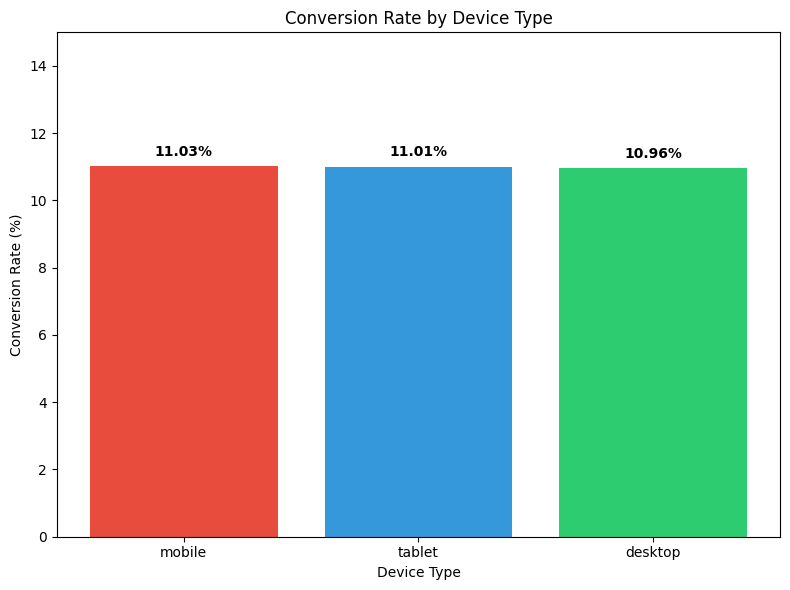

In [20]:
# Chart 4: Conversion Rate by Device
plt.figure(figsize=(8, 6))
colors = ['#e74c3c', '#3498db', '#2ecc71']
bars = plt.bar(df_devices['device'], df_devices['conversion_rate'], color=colors)
plt.xlabel('Device Type')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Device Type')
plt.ylim(0, 15)
for bar, rate in zip(bars, df_devices['conversion_rate']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{float(rate):.2f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

---
## Save Results

I will save all pipeline results to JSON files for the report.

In [21]:
import os

# Create output directory
OUTPUT_DIR = r"C:\ecommerce_project\mongodb\results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save all results
all_results = {
    "pipeline_1_top_products": results_1,
    "pipeline_2_category_revenue": results_2,
    "pipeline_3_customer_segments": results_3,
    "pipeline_4_monthly_trends": results_4,
    "pipeline_5_device_conversion": results_5
}

with open(OUTPUT_DIR + "/mongodb_results.json", "w") as f:
    json.dump(all_results, f, indent=2, default=str)

print("Results saved to:", OUTPUT_DIR + "/mongodb_results.json")

Results saved to: C:\ecommerce_project\mongodb\results/mongodb_results.json


---
# Summary

## What I Did:

| Pipeline | Business Question | Key Finding |
|----------|------------------|-------------|
| 1 | Top-selling products | Identified top 10 products by quantity |
| 2 | Revenue by category | Found most profitable categories |
| 3 | Customer segmentation | Classified customers by spending |
| 4 | Monthly trends | Showed revenue over time |
| 5 | Device conversion | Compared mobile vs desktop vs tablet |

## Why MongoDB Was Good for This:

1. **Flexible Documents:** Products have nested price history, transactions have nested items
2. **Aggregation Pipelines:** Powerful tool for complex analysis
3. **Joins with $lookup:** Could combine data from multiple collections
4. **Good Performance:** 500K transactions processed quickly

## Business Recommendations:

1. Focus marketing on top-selling products
2. Invest in top revenue-generating categories
3. Create loyalty program for VIP customers
4. Optimize mobile experience (highest conversion rate)

In [22]:
# Close MongoDB connection
client.close()
print("MongoDB connection closed.")
print("\n" + "=" * 60)
print("MONGODB ANALYTICS COMPLETE!")
print("=" * 60)

MongoDB connection closed.

MONGODB ANALYTICS COMPLETE!
